In [ ]:
import os
import shutil
import random
from tqdm import tqdm

# Set the seed for reproducibility
random.seed(42)

# Paths
source_dir = '/kaggle/input/paddy-disease-classification/train_images'
output_base = '/kaggle/working/dataset_split'  # New root folder for the split
splits = ['train', 'val', 'test']
split_ratios = [0.8, 0.1, 0.1]

for split in splits:
    for cls in os.listdir(source_dir):
        os.makedirs(os.path.join(output_base, split, cls), exist_ok=True)

for cls in tqdm(os.listdir(source_dir), desc="Splitting dataset by class"):
    cls_path = os.path.join(source_dir, cls)
    if not os.path.isdir(cls_path):
        continue
    images = os.listdir(cls_path)
    random.shuffle(images)

    total = len(images)
    train_count = int(split_ratios[0] * total)
    val_count = int(split_ratios[1] * total)

    train_files = images[:train_count]
    val_files = images[train_count:train_count + val_count]
    test_files = images[train_count + val_count:]

    for split_name, files in zip(splits, [train_files, val_files, test_files]):
        for file in files:
            src = os.path.join(cls_path, file)
            dst = os.path.join(output_base, split_name, cls, file)
            shutil.copy2(src, dst)

print("split.")


In [ ]:

x = layers.Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(1e-4))(x)
x = layers.BatchNormalization()(x)


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV3Large
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import os
from tensorflow.keras import layers, models
import shutil
import random

In [6]:

from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
train_dir="/kaggle/working/dataset_split/train"
valid_dir= "/kaggle/working/dataset_split/val"
test_dir="/kaggle/working/dataset_split/test"


#  data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(0.05, 0.05),
])

# augmentation + preprocessing
def process_with_aug(image, label):
    image = data_augmentation(image) 
    image = preprocess_input(image)   
    return image, label
    
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=64,
    label_mode='categorical',
    shuffle=True,
    seed=22
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    image_size=(224, 224),
    batch_size=64,
    label_mode='categorical',
    shuffle=False,
    seed=22
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=64,
    label_mode='categorical',
    shuffle=False,
    seed=22
)

train_ds = train_ds.map(process_with_aug, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)

val_ds = val_ds.cache()
test_ds = test_ds.cache()

train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


Found 8323 files belonging to 10 classes.
Found 1036 files belonging to 10 classes.
Found 1048 files belonging to 10 classes.


In [ ]:
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(10, activation='softmax')(x)


In [47]:
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  
x = base_model.output
x = layers.Flatten()(base_model.output)
x = layers.Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(1e-4))(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=outputs)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',   
    factor=0.5,           
    patience=3,           
    min_lr=1e-6           
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',   
    patience=5,            
    restore_best_weights=True 
)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_9 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, 112, 112, 16)   │            432 │ rescaling_9[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, 112, 112, 16)   │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_180            │ (None, 112, 112, 16)   │              0 │ conv_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 16)   │            144 │ activation_180[0][0]   │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 16)   │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_171 (ReLU)          │ (None, 112, 112, 16)   │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            256 │ re_lu_171[0][0]        │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_bn  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_add (Add)   │ (None, 112, 112, 16)   │              0 │ activation_180[0][0],  │
│                           │                        │                │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand    │ (None, 112, 112, 64)   │          1,024 │ expanded_conv_add[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand_bn │ (None, 112, 112, 64)   │            256 │ expanded_conv_1_expan… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_172 (ReLU)          │ (None, 112, 112, 64)   │              0 │ expanded_conv_1_expan… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_depth

 Total params: 27,088,522 (103.33 MB)

 Trainable params: 24,091,146 (91.90 MB)

 Non-trainable params: 2,997,376 (11.43 MB)

In [48]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=130,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/130
131/131 ━━━━━━━━━━━━━━━━━━━━ 84s 521ms/step - accuracy: 0.4517 - loss: 2.2204 - val_accuracy: 0.5743 - val_loss: 1.8327 - learning_rate: 0.0010
Epoch 2/130
131/131 ━━━━━━━━━━━━━━━━━━━━ 59s 439ms/step - accuracy: 0.6988 - loss: 1.1295 - val_accuracy: 0.6708 - val_loss: 1.3392 - learning_rate: 0.0010
Epoch 3/130
131/131 ━━━━━━━━━━━━━━━━━━━━ 59s 441ms/step - accuracy: 0.7624 - loss: 0.9852 - val_accuracy: 0.7181 - val_loss: 1.1997 - learning_rate: 0.0010
Epoch 4/130
131/131 ━━━━━━━━━━━━━━━━━━━━ 59s 440ms/step - accuracy: 0.7860 - loss: 0.9350 - val_accuracy: 0.7288 - val_loss: 1.2985 - learning_rate: 0.0010
Epoch 5/130
131/131 ━━━━━━━━━━━━━━━━━━━━ 59s 444ms/step - accuracy: 0.8156 - loss: 0.8995 - val_accuracy: 0.7500 - val_loss: 1.1457 - learning_rate: 0.0010
Epoch 6/130
131/131 ━━━━━━━━━━━━━━━━━━━━ 60s 449ms/step - accuracy: 0.8185 - loss: 0.8851 - val_accuracy: 0.7481 - val_loss: 1.1331 - learning_rate: 0.0010
Epoch 7/130
131/131 ━━━━━━━━━━━━━━━━━━━━ 60s 445ms/step - accura

In [49]:
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report

y_true = []
y_pred = []

for images, labels in test_ds:  # or val_ds
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [50]:
from sklearn.metrics import precision_score

accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')  
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)
print(f"Precision (macro): {precision:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1-score (macro): {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 0.8831 - loss: 0.6019
Test accuracy : 0.8998091816902161
Precision (macro): 0.8997
Accuracy: 0.8998
Recall (macro): 0.8789
F1-score (macro): 0.8874
Confusion Matrix:
[[ 41   1   1   1   2   0   1   0   1   1]
 [  0  32   0   4   2   0   0   0   0   0]
 [  0   0  28   0   1   5   0   0   1   0]
 [  0   0   0 162   4   0   2   0   0   7]
 [  0   1   0   2  87   1   0   1   1   4]
 [  0   0   1   1   1 137   1   1   2   1]
 [  1   1   0   7   3   0  50   0   0   0]
 [  1   0   0   3   8   0   2 141   2   3]
 [  1   0   0   6   1   3   1   3 161   1]
 [  1   0   0   2   2   0   0   1   0 104]]


In [51]:
print("Classification Report:")
print(classification_report(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87        49
           1       0.91      0.84      0.88        38
           2       0.93      0.80      0.86        35
           3       0.86      0.93      0.89       175
           4       0.78      0.90      0.84        97
           5       0.94      0.94      0.94       145
           6       0.88      0.81      0.84        62
           7       0.96      0.88      0.92       160
           8       0.96      0.91      0.93       177
           9       0.86      0.95      0.90       110

    accuracy                           0.90      1048
   macro avg       0.90      0.88      0.89      1048
weighted avg       0.90      0.90      0.90      1048



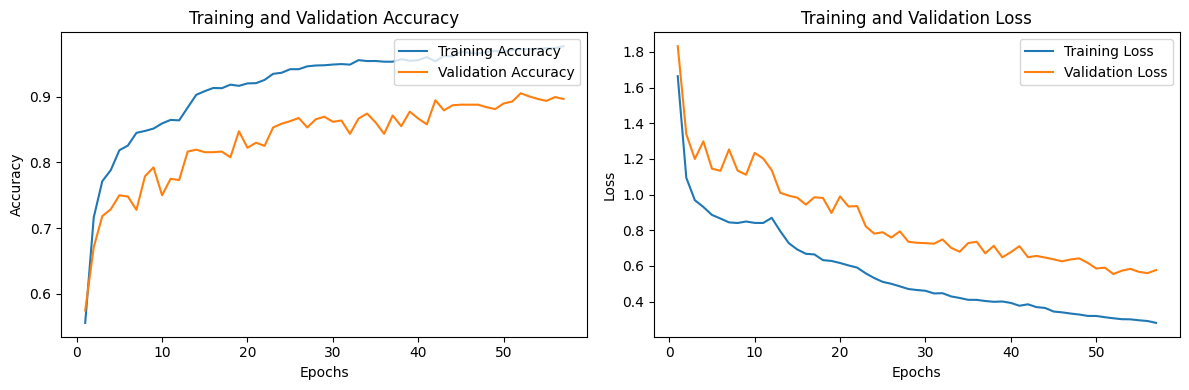

In [52]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

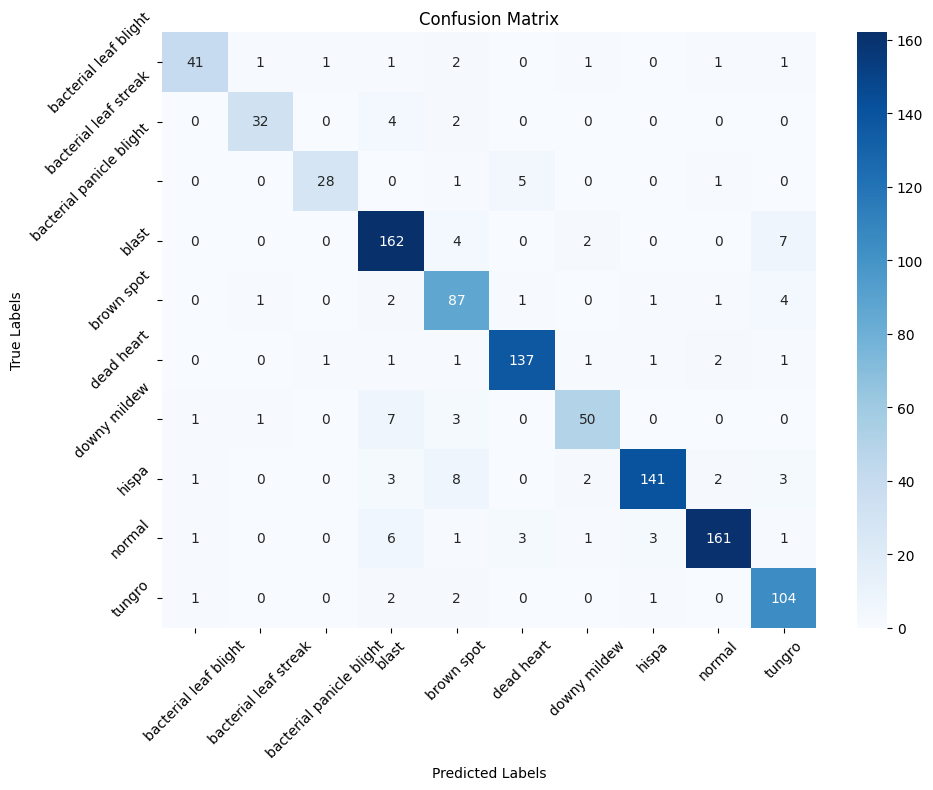

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assume y_true and y_pred are your ground truths and predictions
conf_mat = confusion_matrix(y_true, y_pred)

# Optional: If you have class labels
class_names = ['bacterial leaf blight', 'bacterial leaf streak', 'bacterial panicle blight',
               'blast', 'brown spot', 'dead heart', 'downy mildew', 'hispa',
               'normal', 'tungro']  # Update with your class labels

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


In [54]:
model_save_path = '/kaggle/working/Mobilenetv3large_paddy_disease_detection_architecture_3_not_fine_tuned.h5'
model.save(model_save_path)

In [58]:
# ✅ Better way to save
model.save("Mobilenetv3large_paddy_disease_detection_architecture_3_not_fine_tuned.keras")


In [70]:
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))
    
download_file('/kaggle/working/Mobilenetv3large_paddy_disease_detection_architecture_3_not_fine_tuned.keras', 'out')

/kaggle/working/out.zip

In [68]:
baseline_model = tf.keras.models.load_model("/kaggle/working/Mobilenetv3large_paddy_disease_detection_architecture_3_not_fine_tuned.keras")

for i, layer in enumerate(model.layers):
    print(i, layer.name)


0 input_layer_12
1 rescaling_9
2 conv
3 conv_bn
4 activation_180
5 expanded_conv_depthwise
6 expanded_conv_depthwise_bn
7 re_lu_171
8 expanded_conv_project
9 expanded_conv_project_bn
10 expanded_conv_add
11 expanded_conv_1_expand
12 expanded_conv_1_expand_bn
13 re_lu_172
14 expanded_conv_1_depthwise_pad
15 expanded_conv_1_depthwise
16 expanded_conv_1_depthwise_bn
17 re_lu_173
18 expanded_conv_1_project
19 expanded_conv_1_project_bn
20 expanded_conv_2_expand
21 expanded_conv_2_expand_bn
22 re_lu_174
23 expanded_conv_2_depthwise
24 expanded_conv_2_depthwise_bn
25 re_lu_175
26 expanded_conv_2_project
27 expanded_conv_2_project_bn
28 expanded_conv_2_add
29 expanded_conv_3_expand
30 expanded_conv_3_expand_bn
31 re_lu_176
32 expanded_conv_3_depthwise_pad
33 expanded_conv_3_depthwise
34 expanded_conv_3_depthwise_bn
35 re_lu_177
36 expanded_conv_3_squeeze_excite_avg_pool
37 expanded_conv_3_squeeze_excite_conv
38 expanded_conv_3_squeeze_excite_relu
39 expanded_conv_3_squeeze_excite_conv_1
40 re

In [72]:
base_model = model.layers[2]

base_model.trainable = True

# Freeze all layers up to a certain layer
for layer in model.layers[140:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,  # fewer epochs for fine-tuning
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 101s 560ms/step - accuracy: 0.9558 - loss: 0.3437 - val_accuracy: 0.8909 - val_loss: 0.6108 - learning_rate: 1.0000e-05
Epoch 2/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 60s 444ms/step - accuracy: 0.9597 - loss: 0.3285 - val_accuracy: 0.8871 - val_loss: 0.6035 - learning_rate: 1.0000e-05
Epoch 3/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 59s 437ms/step - accuracy: 0.9607 - loss: 0.3271 - val_accuracy: 0.8832 - val_loss: 0.6180 - learning_rate: 1.0000e-05
Epoch 4/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 60s 446ms/step - accuracy: 0.9615 - loss: 0.3114 - val_accuracy: 0.8919 - val_loss: 0.5972 - learning_rate: 1.0000e-05
Epoch 5/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 59s 443ms/step - accuracy: 0.9636 - loss: 0.3219 - val_accuracy: 0.8958 - val_loss: 0.5731 - learning_rate: 1.0000e-05
Epoch 6/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 59s 443ms/step - accuracy: 0.9653 - loss: 0.3091 - val_accuracy: 0.8958 - val_loss: 0.5673 - learning_rate: 1.0000e-05
Epoch 7/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 60s 4

In [73]:
y_true = []
y_pred = []

for images, labels in test_ds:  # or val_ds
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [74]:
from sklearn.metrics import precision_score

accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')  
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)
print(f"Precision (macro): {precision:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1-score (macro): {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step - accuracy: 0.9007 - loss: 0.5123
Test accuracy : 0.9036259651184082
Precision (macro): 0.9026
Accuracy: 0.9036
Recall (macro): 0.8929
F1-score (macro): 0.8963
Confusion Matrix:
[[ 42   1   0   0   1   0   5   0   0   0]
 [  0  32   0   1   1   0   1   1   0   2]
 [  0   0  33   0   0   1   0   0   0   1]
 [  0   0   0 166   2   0   2   1   2   2]
 [  1   0   0   2  87   0   2   0   2   3]
 [  0   1   0   2   1 138   2   0   1   0]
 [  0   1   0   2   4   0  51   1   3   0]
 [  1   1   0   7  10   1   4 130   4   2]
 [  0   0   0   4   1   0   1   2 169   0]
 [  0   0   0   3   2   0   1   4   1  99]]


In [75]:
print("Classification Report:")
print(classification_report(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.86      0.90        49
           1       0.89      0.84      0.86        38
           2       1.00      0.94      0.97        35
           3       0.89      0.95      0.92       175
           4       0.80      0.90      0.84        97
           5       0.99      0.95      0.97       145
           6       0.74      0.82      0.78        62
           7       0.94      0.81      0.87       160
           8       0.93      0.95      0.94       177
           9       0.91      0.90      0.90       110

    accuracy                           0.90      1048
   macro avg       0.90      0.89      0.90      1048
weighted avg       0.91      0.90      0.90      1048



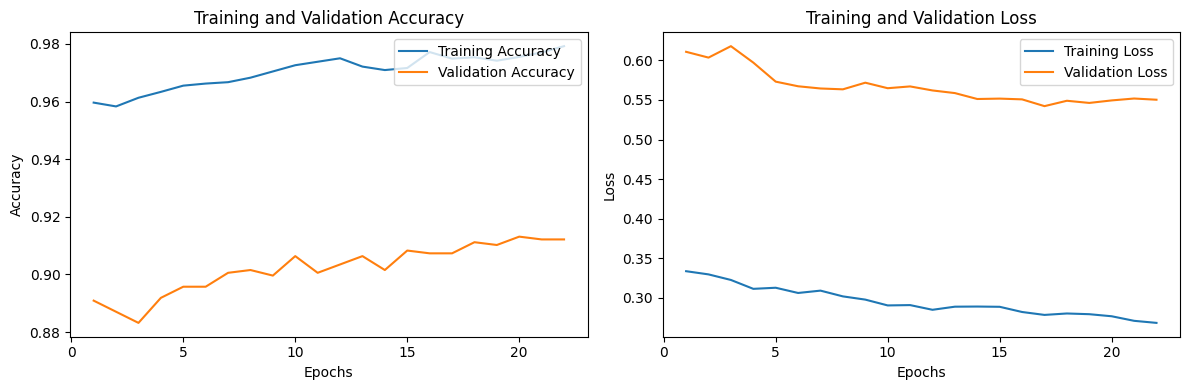

In [76]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

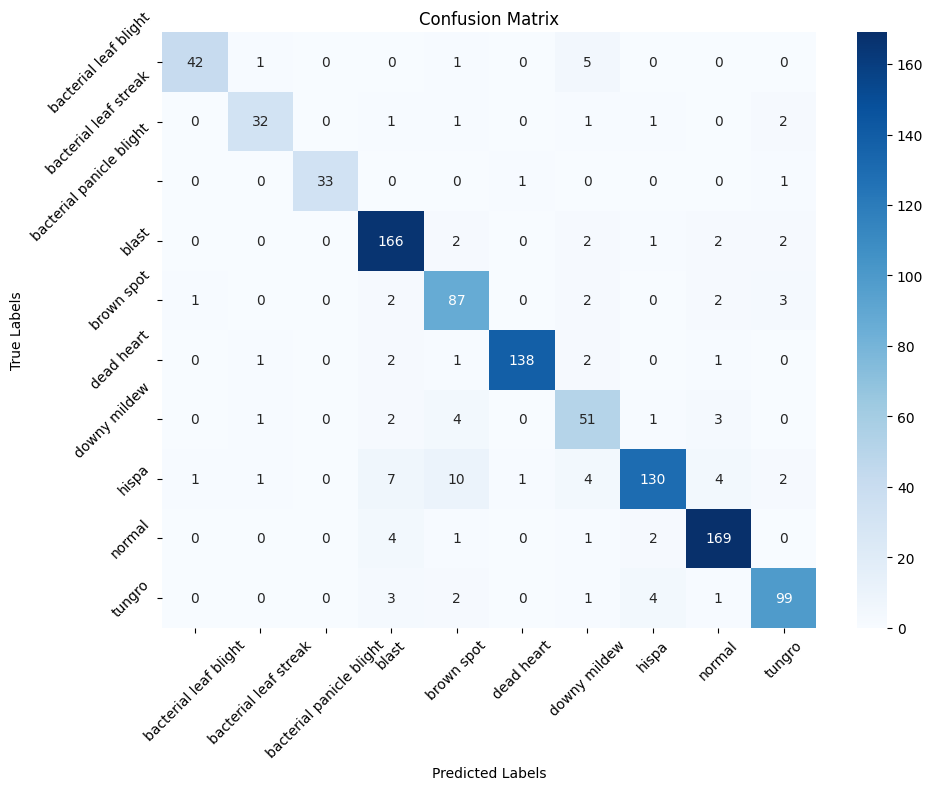

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true, y_pred)

# Optional: If you have class labels
class_names = ['bacterial leaf blight', 'bacterial leaf streak', 'bacterial panicle blight',
               'blast', 'brown spot', 'dead heart', 'downy mildew', 'hispa',
               'normal', 'tungro']  
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


In [81]:
model_save_path = '/kaggle/working/Mobilenetv3large_paddy_disease_detection_architecture_3_fine_tuned.h5'
model.save(model_save_path)

In [82]:
model.save("Mobilenetv3large_paddy_disease_detection_architecture_3_fine_tuned.keras")


In [84]:

import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))
    
download_file('/kaggle/working/Mobilenetv3large_paddy_disease_detection_architecture_3_fine_tuned.h5', 'out')

/kaggle/working/out.zip